# Random Forest classifier Efficacy for behaviour position via Wifi CSI

## Core Modules

In [1]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

## Importing Data
I use the data import script from Veena Suresh's SVM

In [2]:
# Define the path to the dataset
dataset_path = 'Room2_npy'

# Define the target length for data trimming/padding
target_length = 750

data_list = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup", "walk"]

# Helper function to split sequences
def split_sequence(sequence, step):
    return [sequence[i:i + step] for i in range(0, len(sequence), step) if len(sequence[i:i + step]) == step]

# Traverse through each activity directory
for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
    print(f"Processing activity: {activity_folder}")

    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                print(f"Loading data from file: {participant_file}")
                data = np.load(participant_path)
                data = np.real(data)

                # Split data into smaller sequences
                data_splits = split_sequence(data, target_length)

                for split_data in data_splits:
                    # Normalize data
                    min_val = np.min(split_data)
                    max_val = np.max(split_data)
                    data_normalized = (split_data - min_val) / (max_val - min_val) if max_val != min_val else np.zeros(split_data.shape)

                    label = activity_folder
                    data_list.append(data_normalized)
                    labels_list.append(label)

                    if label in classes_to_double:
                        data_list.append(data_normalized.copy())  # Double the data
                        labels_list.append(label)  # Double the label

# Convert lists to arrays for machine learning processing
data = np.array(data_list)
labels = np.array(labels_list).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output=False to get a dense array
labels = encoder.fit_transform(labels)

print("Final data shape:", data.shape)
print("Final labels shape:", labels.shape)

Processing activity: kneel
Loading data from file: kneel_1.npy
Loading data from file: kneel_10.npy
Loading data from file: kneel_2.npy
Loading data from file: kneel_3.npy
Loading data from file: kneel_4.npy
Loading data from file: kneel_5.npy
Loading data from file: kneel_6.npy
Loading data from file: kneel_7.npy
Loading data from file: kneel_8.npy
Loading data from file: kneel_9.npy
Processing activity: liedown
Loading data from file: liedown_1.npy
Loading data from file: liedown_10.npy
Loading data from file: liedown_2.npy
Loading data from file: liedown_3.npy
Loading data from file: liedown_4.npy
Loading data from file: liedown_5.npy
Loading data from file: liedown_6.npy
Loading data from file: liedown_7.npy
Loading data from file: liedown_8.npy
Loading data from file: liedown_9.npy
Processing activity: pickup
Loading data from file: pickup_10.npy
Loading data from file: pickup_2.npy
Loading data from file: pickup_3.npy
Loading data from file: pickup_4.npy
Loading data from file: p

## Data Preprocessing
I looked at both PCA and Feature selection and decided feature selection worked better in this dataset as it can capture more of the data in less features.

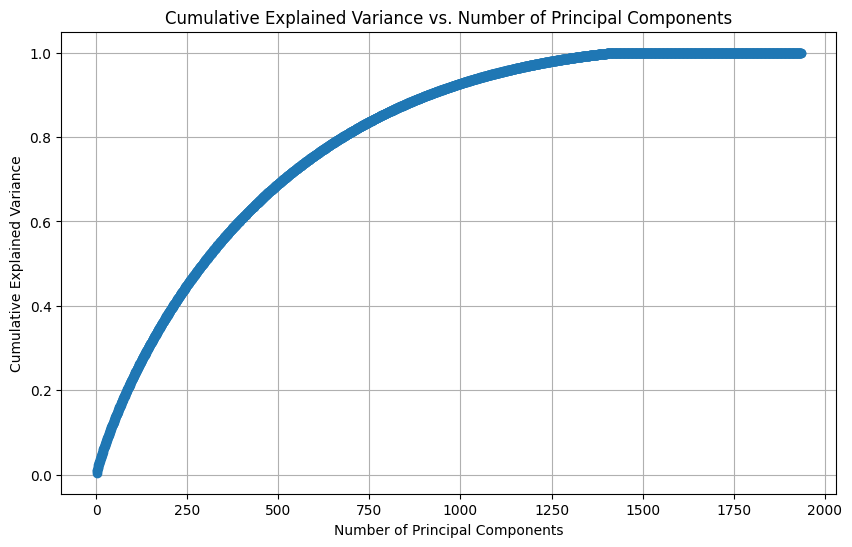

Optimal number of components to retain 95.0% variance: 1093


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten the data if necessary (e.g., if it's 3D: (samples, timesteps, features))
data_flattened = data.reshape(data.shape[0], -1)  # Ensure data is now (114, num_features)

# Perform PCA on the entire dataset
pca = PCA()
data_pca = pca.fit_transform(data_flattened)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Lower the variance threshold to 95%
threshold = 0.95
optimal_n = np.argmax(cumulative_variance >= threshold) + 1
print(f'Optimal number of components to retain {threshold * 100}% variance: {optimal_n}')

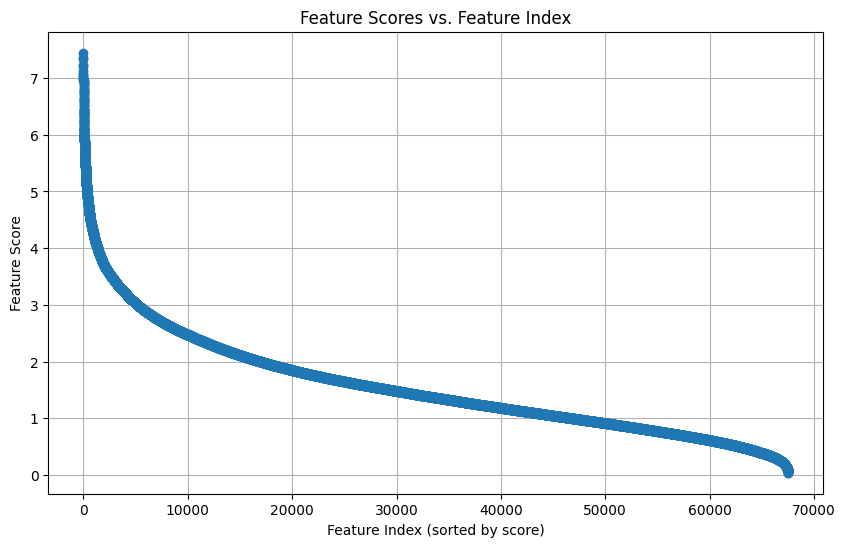

Optimal number of features to retain based on score threshold: 13500
Selected data shape: (1935, 13500)


In [4]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset and 'labels' is your one-hot encoded target variable

# Flatten the data if necessary (e.g., if it's 3D: (samples, timesteps, features))
#data_flattened = data.reshape(data.shape[0], -1)

# Convert the one-hot encoded labels to a 1D array of class labels
labels_1d = np.argmax(labels, axis=1)

# Apply SelectKBest feature selection
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' means to score all features
selector.fit(data_flattened, labels_1d)

# Get scores and p-values
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_

# Sort features by score in descending order
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_scores = feature_scores[sorted_indices]
sorted_pvalues = feature_pvalues[sorted_indices]

# Plot the feature scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_scores) + 1), sorted_scores, marker='o', linestyle='--')
plt.title('Feature Scores vs. Feature Index')
plt.xlabel('Feature Index (sorted by score)')
plt.ylabel('Feature Score')
plt.grid(True)
plt.show()

# Determine optimal k based on a desired score threshold
# For example, retain features with a score higher than a certain threshold (e.g., top 25%)
score_threshold = np.percentile(sorted_scores, 80)  # Keep top 25% of features based on score
optimal_k = np.sum(sorted_scores >= score_threshold)
print(f'Optimal number of features to retain based on score threshold: {optimal_k}')

# Apply the feature selection with the optimal number of features
selector = SelectKBest(score_func=f_classif, k=optimal_k)
data_selected = selector.fit_transform(data_flattened, labels_1d)

# Output the shape of the selected data
print(f'Selected data shape: {data_selected.shape}')

## Test Train split
Made a 60-40 split firstly, then split the 40 into a 20-20 test validation split using stratified splitting.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

# First, split the data into training (60%) and remaining (40%) sets
X_train, X_rem, y_train, y_rem = train_test_split(
    data_selected, labels_1d, test_size=0.4, stratify=labels_1d, random_state=42
)

# Now split the remaining data into validation (50% of 40% = 20%) and test (50% of 40% = 20%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=42
)

# Output the shapes of the resulting datasets
print(f'Training data shape: {X_train.shape}') 
print(f'Validation data shape: {X_val.shape}') 
print(f'Test data shape: {X_test.shape}')      
print(f'Training labels shape: {y_train.shape}') 
print(f'Validation labels shape: {y_val.shape}')  
print(f'Test labels shape: {y_test.shape}')      

# Verify class distribution in the splits
print(f'Training class distribution: {np.bincount(y_train)}')
print(f'Validation class distribution: {np.bincount(y_val)}')
print(f'Test class distribution: {np.bincount(y_test)}')


Training data shape: (1161, 13500)
Validation data shape: (387, 13500)
Test data shape: (387, 13500)
Training labels shape: (1161,)
Validation labels shape: (387,)
Test labels shape: (387,)
Training class distribution: [156 156 140 151 143 135 135 145]
Validation class distribution: [52 52 47 50 47 45 45 49]
Test class distribution: [52 52 47 50 48 45 45 48]


## HyperParam Tuning
Was quite hard to figure out good values, as running this took a long time.

In [11]:
# Define the parameter ranges
param_grid = {
    'n_estimators': [100, 500],  # Reduced number of trees for faster training
    'max_depth': [5, 25, 50],      # Shallower trees for faster evaluation
    'min_samples_split': [5, 10, 15],  # Default and slightly increased values
    'min_samples_leaf': [7, 12],   # Default and slightly increased values
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'random_state': [42],
    'n_jobs': [-1]
}

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

# First, split the data into half
X_half, X_unused, y_half, y_unused = train_test_split(data_selected, labels_1d, test_size=0.5, stratify=labels_1d, random_state=42)

# Now split the half into training (40%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_half, y_half, test_size=0.333, stratify=y_half, random_state=42)

# Define the RandomForestClassifier
clf_rf = RandomForestClassifier()

# Perform GridSearchCV with a focus on validation performance using f1_macro
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

print("Hyperparameters optimization results:")
for param_name in best_params:
    print(f"{param_name}: {best_params[param_name]}")

# Initialize the optimized RandomForestClassifier with the best hyperparameters
clf_rf_opt = RandomForestClassifier(**best_params)

# Fit the optimized model on the training data
clf_rf_opt.fit(X_train, y_train)

# Predict on training, validation, and test sets
y_pred_tr = clf_rf_opt.predict(X_train)
y_pred_val = clf_rf_opt.predict(X_val)
y_pred_te = clf_rf_opt.predict(X_test)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_pred_tr, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')
f1_test = f1_score(y_test, y_pred_te, average='macro')

print(f"F1 Score (Train): {f1_train:.2f}")
print(f"F1 Score (Validation): {f1_val:.2f}")
print(f"F1 Score (Test): {f1_test:.2f}")

Hyperparameters optimization results:
bootstrap: True
max_depth: 25
max_features: sqrt
min_samples_leaf: 7
min_samples_split: 5
n_estimators: 500
n_jobs: -1
random_state: 42
F1 Score (Train): 1.00
F1 Score (Validation): 0.56
F1 Score (Test): 0.53


In [13]:
## Training Full Model

In [14]:
clf_rf_opt_full = RandomForestClassifier(**best_params)
clf_rf_opt_full.fit(data_selected, labels_1d)

RandomForestClassifier(max_depth=25, min_samples_leaf=7, min_samples_split=5,
                       n_estimators=500, n_jobs=-1, random_state=42)

Accuracy: 0.58
Precision (Macro Average): 0.56
Recall (Macro Average): 0.57
F1 Score (Macro Average): 0.53


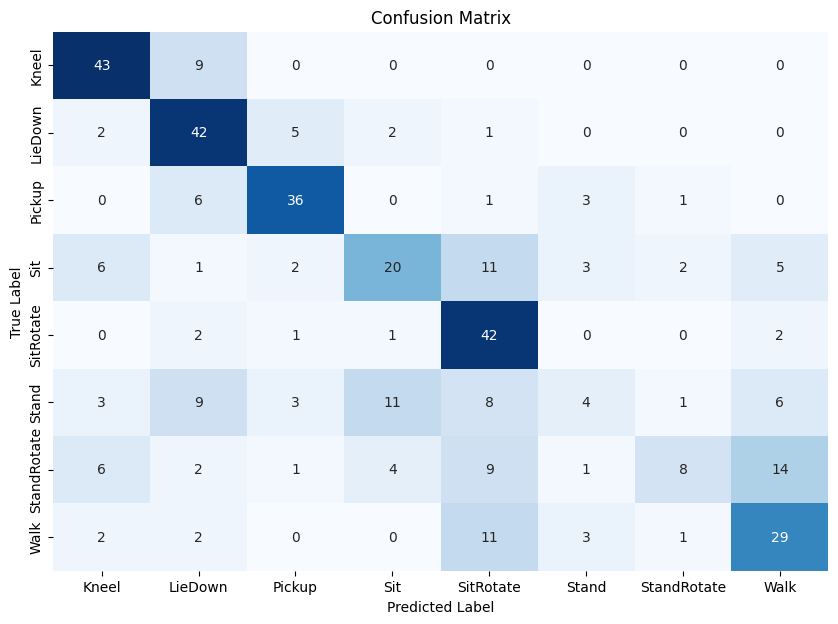

In [15]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model_performance(model, X_test, y_test):

    class_labels = ("Kneel", "LieDown", "Pickup", "Sit", "SitRotate", "Stand", "StandRotate", "Walk")
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate precision, recall, and F1 score with zero_division handling
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Print the results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (Macro Average): {precision:.2f}")
    print(f"Recall (Macro Average): {recall:.2f}")
    print(f"F1 Score (Macro Average): {f1:.2f}")
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, conf_matrix, precision, recall, f1


evaluate_model_performance(clf_rf_opt, X_test, y_test)
print("")

## Results:


My random forest has reach an accuracy of 58%. As of now the LSTM model made by Veena has an accuracy of 79%, which is significantly more accurate.
Overall overfitting is a massive problem with the random forest, and it seems unlikely that the random forest can create a viable model for real world use with if this is close to the best it can perform.